In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/eli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Unigrams

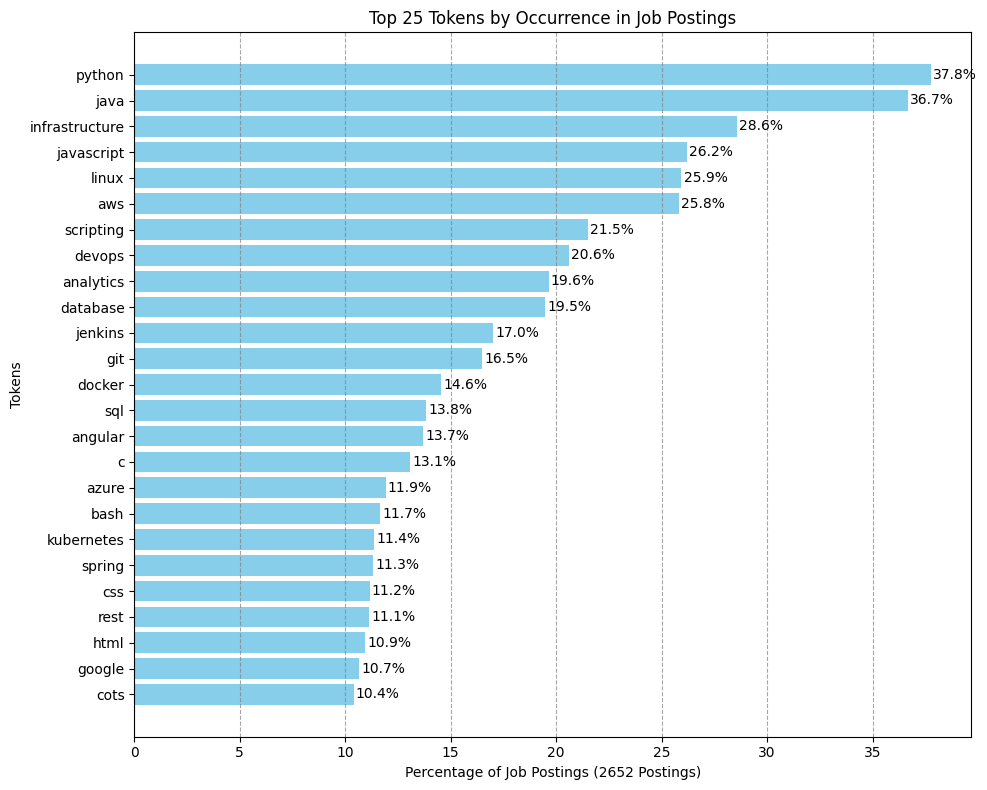

Total job postings count: 2652
Top 150 Tokens (Token - Percentage of Job Postings Token is Mentioned):
python - 37.78%
java - 36.69%
infrastructure - 28.58%
javascript - 26.21%
linux - 25.94%
aws - 25.83%
scripting - 21.49%
devops - 20.59%
analytics - 19.65%
database - 19.49%
jenkins - 17.01%
git - 16.48%
docker - 14.56%
sql - 13.84%
angular - 13.69%
c - 13.08%
azure - 11.92%
bash - 11.65%
kubernetes - 11.39%
spring - 11.31%
css - 11.16%
rest - 11.12%
html - 10.94%
google - 10.67%
cots - 10.41%
unix - 9.95%
scripts - 9.73%
elasticsearch - 9.24%
ansible - 8.97%
react - 8.79%
cybersecurity - 8.22%
apis - 8.18%
gots - 8.11%
gitlab - 7.99%
protocols - 7.62%
github - 7.50%
rds - 7.50%
excel - 7.39%
junit - 7.20%
virtualization - 7.16%
servers - 7.05%
oracle - 6.98%
springboot - 6.83%
cisco - 6.41%
relational - 6.37%
api - 6.33%
modeling - 6.30%
nosql - 6.11%
distributed - 6.11%
ui - 6.07%
restful - 6.07%
pipelines - 6.00%
mysql - 6.00%
json - 5.92%
nifi - 5.92%
apache - 5.81%
ms - 5.69%
per

In [10]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, udf
from pyspark.sql.types import StringType, ArrayType
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from custom_stop_words import custom_stop_words

spark = SparkSession.builder.appName("JobDescriptions").getOrCreate()

# Load NLTK stop words and define custom stop words
nltk_stop_words = set(stopwords.words('english'))

all_stop_words = nltk_stop_words.union(custom_stop_words)

broadcast_stop_words = spark.sparkContext.broadcast(all_stop_words)

conn = sqlite3.connect('jobs.db')
job_descriptions_df = pd.read_sql_query("SELECT description FROM jobs", conn)
conn.close()

total_job_descriptions = len(job_descriptions_df)
spark_df = spark.createDataFrame(job_descriptions_df)

def tokenize_and_filter(text):
    tokens = word_tokenize(text)
    stop_words = broadcast_stop_words.value
    # Convert the token list to a set to ensure uniqueness within each job description
    return list(set([word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]))

tokenize_and_filter_udf = udf(tokenize_and_filter, ArrayType(StringType()))
filtered_tokens_df = spark_df.withColumn("filtered_tokens", tokenize_and_filter_udf(col("description")))
exploded_df = filtered_tokens_df.withColumn("token", explode(col("filtered_tokens")))
token_counts = exploded_df.groupBy("token").count().orderBy(col("count").desc())
top_tokens = token_counts.limit(150).collect()

tokens = [row['token'] for row in top_tokens]
percentages = [(row['count'] / total_job_descriptions) * 100 for row in top_tokens]
show_on_plot = 25

plt.figure(figsize=(10, 8))
bars = plt.barh(tokens[:show_on_plot][::-1], percentages[:show_on_plot][::-1], color='skyblue')
plt.xlabel('Percentage of Job Postings (2652 Postings)')
plt.ylabel('Tokens')
plt.title(f'Top {show_on_plot} Tokens by Occurrence in Job Postings')
plt.grid(True, axis='x', linestyle='--', color='gray', alpha=0.7)

# Add percentage labels at the end of each bar
for bar, percentage in zip(bars, percentages[:show_on_plot][::-1]):
    plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, f'{percentage:.1f}%', va='center')

plt.tight_layout()
plt.show()

print(f"Total job postings count: {total_job_descriptions}")
print("Top 150 Tokens (Token - Percentage of Job Postings Token is Mentioned):")

for row in top_tokens:
    percentage = (row['count'] / total_job_descriptions) * 100
    print(f"{row['token']} - {percentage:.2f}%")

spark.stop()


In [279]:
import re

def format_for_custom_stop_words(input_string, start_at_word=0):
    # Use regex to extract words within single quotes
    words = re.findall(r"'(\w+)'", input_string)[start_at_word:]
    # Format as a comma-separated string with single quotes around each word
    formatted = ", ".join([f"'{word}'" for word in words]) + ","
    return formatted

Bigrams

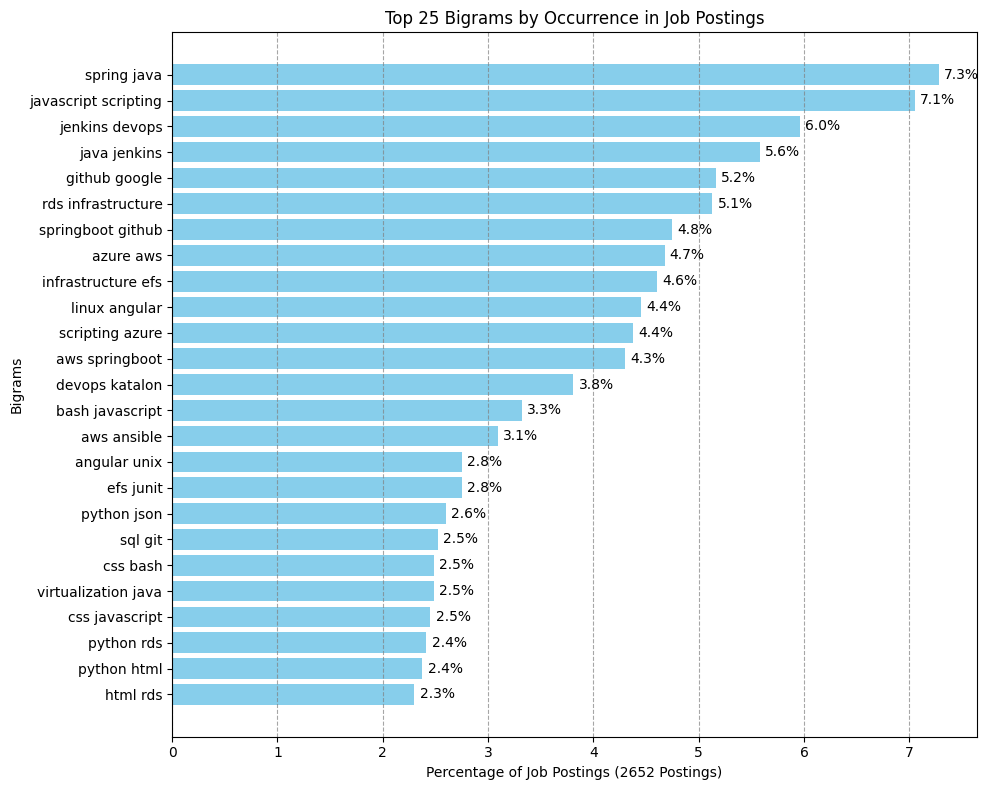

Total job postings count: 2652
Top 150 Bigrams (Bigram - Percentage of Job Postings Bigram is Mentioned):
spring java - 7.28%
javascript scripting - 7.05%
jenkins devops - 5.96%
java jenkins - 5.58%
github google - 5.17%
rds infrastructure - 5.13%
springboot github - 4.75%
azure aws - 4.68%
infrastructure efs - 4.60%
linux angular - 4.45%
scripting azure - 4.37%
aws springboot - 4.30%
devops katalon - 3.81%
bash javascript - 3.32%
aws ansible - 3.09%
angular unix - 2.75%
efs junit - 2.75%
python json - 2.60%
sql git - 2.53%
css bash - 2.49%
virtualization java - 2.49%
css javascript - 2.45%
python rds - 2.41%
python html - 2.38%
html rds - 2.30%
analytics kubernetes - 2.26%
elasticsearch docker - 2.22%
scripting javascript - 2.19%
gots analytics - 2.19%
restful python - 2.15%
junit angular - 2.07%
java maven - 2.04%
excel python - 1.96%
java postgresql - 1.85%
apis css - 1.81%
c devops - 1.77%
kubernetes infrastructure - 1.77%
google std - 1.77%
unix spring - 1.66%
python analytics - 1

In [7]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, udf
from pyspark.sql.types import StringType, ArrayType
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import bigrams
from custom_stop_words import custom_stop_words

spark = SparkSession.builder.appName("JobDescriptions").getOrCreate()

# Load NLTK stop words and define custom stop words
nltk_stop_words = set(stopwords.words('english'))

all_stop_words = nltk_stop_words.union(custom_stop_words)

# Broadcast the stop words to all workers
broadcast_stop_words = spark.sparkContext.broadcast(all_stop_words)

conn = sqlite3.connect('jobs.db')
job_descriptions_df = pd.read_sql_query("SELECT description FROM jobs", conn)
conn.close()

total_job_descriptions = len(job_descriptions_df)
spark_df = spark.createDataFrame(job_descriptions_df)

def tokenize_filter_bigrams(text):
    tokens = word_tokenize(text)
    stop_words = broadcast_stop_words.value
    filtered_tokens = list(set([word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]))
    bigrams_list = [' '.join(bigram) for bigram in bigrams(filtered_tokens)]
    return bigrams_list

tokenize_filter_bigrams_udf = udf(tokenize_filter_bigrams, ArrayType(StringType()))

# Apply tokenization, filtering, and bigram generation
filtered_bigrams_df = spark_df.withColumn("filtered_bigrams", tokenize_filter_bigrams_udf(col("description")))

# Explode the bigrams for frequency count
exploded_bigrams_df = filtered_bigrams_df.withColumn("bigram", explode(col("filtered_bigrams")))
bigram_counts = exploded_bigrams_df.groupBy("bigram").count().orderBy(col("count").desc())
top_bigrams = bigram_counts.limit(150).collect()

bigrams_list = [row['bigram'] for row in top_bigrams]
percentages = [(row['count'] / total_job_descriptions) * 100 for row in top_bigrams]
show_on_plot = 25 

plt.figure(figsize=(10, 8))
bars = plt.barh(bigrams_list[:show_on_plot][::-1], percentages[:show_on_plot][::-1], color='skyblue') 
plt.xlabel(f'Percentage of Job Postings ({total_job_descriptions} Postings)')
plt.ylabel('Bigrams')
plt.title(f'Top {show_on_plot} Bigrams by Occurrence in Job Postings')
plt.grid(True, axis='x', linestyle='--', color='gray', alpha=0.7)

# Add percentage labels at the end of each bar
for bar, percentage in zip(bars, percentages[:show_on_plot][::-1]):
    plt.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height()/2, f'{percentage:.1f}%', va='center')

plt.tight_layout()
plt.show()

print(f"Total job postings count: {total_job_descriptions}")
print("Top 150 Bigrams (Bigram - Percentage of Job Postings Bigram is Mentioned):")

for row in top_bigrams:
    percentage = (row['count'] / total_job_descriptions) * 100
    print(f"{row['bigram']} - {percentage:.2f}%")

spark.stop()


Trigrams

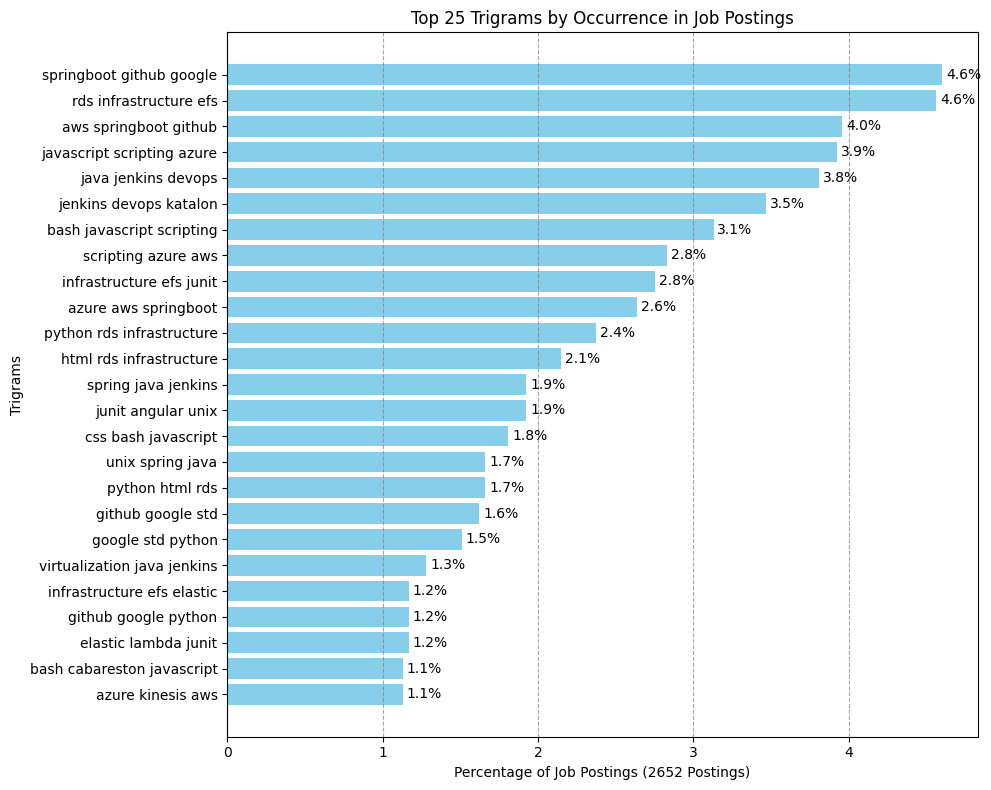

Total job postings count: 2652
Top 150 Trigrams (Trigram - Percentage of Job Postings Trigram is Mentioned):
springboot github google - 4.60%
rds infrastructure efs - 4.56%
aws springboot github - 3.96%
javascript scripting azure - 3.92%
java jenkins devops - 3.81%
jenkins devops katalon - 3.47%
bash javascript scripting - 3.13%
scripting azure aws - 2.83%
infrastructure efs junit - 2.75%
azure aws springboot - 2.64%
python rds infrastructure - 2.38%
html rds infrastructure - 2.15%
spring java jenkins - 1.92%
junit angular unix - 1.92%
css bash javascript - 1.81%
unix spring java - 1.66%
python html rds - 1.66%
github google std - 1.62%
google std python - 1.51%
virtualization java jenkins - 1.28%
infrastructure efs elastic - 1.17%
github google python - 1.17%
elastic lambda junit - 1.17%
bash cabareston javascript - 1.13%
azure kinesis aws - 1.13%
efs elastic lambda - 1.13%
cabareston javascript scripting - 1.13%
scripting azure kinesis - 1.13%
efs junit angular - 1.09%
unix java jenk

In [9]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, udf
from pyspark.sql.types import StringType, ArrayType
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import trigrams
from custom_stop_words import custom_stop_words

spark = SparkSession.builder.appName("JobDescriptions").getOrCreate()

# Load NLTK stop words and define custom stop words
nltk_stop_words = set(stopwords.words('english'))

all_stop_words = nltk_stop_words.union(custom_stop_words)

# Broadcast the stop words to all workers
broadcast_stop_words = spark.sparkContext.broadcast(all_stop_words)

conn = sqlite3.connect('jobs.db')
job_descriptions_df = pd.read_sql_query("SELECT description FROM jobs", conn)
conn.close()

total_job_descriptions = len(job_descriptions_df)
spark_df = spark.createDataFrame(job_descriptions_df)

def tokenize_filter_trigrams(text):
    tokens = word_tokenize(text)
    stop_words = broadcast_stop_words.value
    filtered_tokens = list(set([word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]))
    trigrams_list = [' '.join(trigram) for trigram in trigrams(filtered_tokens)]
    return trigrams_list

tokenize_filter_trigrams_udf = udf(tokenize_filter_trigrams, ArrayType(StringType()))
# Apply tokenization, filtering, and trigram generation
filtered_trigrams_df = spark_df.withColumn("filtered_trigrams", tokenize_filter_trigrams_udf(col("description")))

# Explode the trigrams for frequency count
exploded_trigrams_df = filtered_trigrams_df.withColumn("trigram", explode(col("filtered_trigrams")))

trigram_counts = exploded_trigrams_df.groupBy("trigram").count().orderBy(col("count").desc())
top_trigrams = trigram_counts.limit(150).collect()

trigrams_list = [row['trigram'] for row in top_trigrams]
percentages = [(row['count'] / total_job_descriptions) * 100 for row in top_trigrams]
show_on_plot = 25 

plt.figure(figsize=(10, 8))
bars = plt.barh(trigrams_list[:show_on_plot][::-1], percentages[:show_on_plot][::-1], color='skyblue')
plt.xlabel(f'Percentage of Job Postings ({total_job_descriptions} Postings)')
plt.ylabel('Trigrams')
plt.title(f'Top {show_on_plot} Trigrams by Occurrence in Job Postings')
plt.grid(True, axis='x', linestyle='--', color='gray', alpha=0.7)

# Add percentage labels at the end of each bar
for bar, percentage in zip(bars, percentages[:show_on_plot][::-1]):
    plt.text(bar.get_width() + 0.025, bar.get_y() + bar.get_height()/2, f'{percentage:.1f}%', va='center')

plt.tight_layout()
plt.show()

print(f"Total job postings count: {total_job_descriptions}")
print("Top 150 Trigrams (Trigram - Percentage of Job Postings Trigram is Mentioned):")

for row in top_trigrams:
    percentage = (row['count'] / total_job_descriptions) * 100
    print(f"{row['trigram']} - {percentage:.2f}%")

spark.stop()
